## Import Libraries

In [173]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

%matplotlib inline

## Load the Data

In [174]:
df = pd.read_csv("data_saudi_used_cars.csv")

In [175]:
df.shape

(5624, 11)

In [176]:
df.head(2)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [177]:
# uniqeness
df[df.duplicated(keep='first')]
df = df.drop_duplicates()
df[df.duplicated()]


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price


In [178]:
# Completeness
df.isnull().sum()

Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64

In [179]:
df

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True,0
...,...,...,...,...,...,...,...,...,...,...,...
5619,X-Trail,Jeddah,Nissan,Automatic,Saudi,Standard,2018,2.5,78794,False,68000
5620,Altima,Jeddah,Nissan,Automatic,Saudi,Semi Full,2020,2.5,58000,True,0
5621,Yukon,Dammam,GMC,Automatic,Saudi,Full,2016,5.3,48000,False,145000
5622,RX,Dammam,Lexus,Automatic,Gulf Arabic,Full,2016,2.5,81000,False,154000


In [180]:
# Accurecy types
df.dtypes

Type            object
Region          object
Make            object
Gear_Type       object
Origin          object
Options         object
Year             int64
Engine_Size    float64
Mileage          int64
Negotiable        bool
Price            int64
dtype: object

In [181]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
categorical_features = ['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']
numeric_features = ['Year', 'Engine_Size', 'Mileage']

In [182]:
for i in categorical_features:
    print (df[i].value_counts())

Type
Land Cruiser    269
Camry           233
Hilux           207
Accent          174
Yukon           162
               ... 
Nativa            1
360               1
GC7               1
CT5               1
S8                1
Name: count, Length: 347, dtype: int64
Region
Riyadh            2270
Dammam             924
Jeddah             732
Qassim             225
Al-Medina          214
Al-Ahsa            166
Aseer              163
Makkah             153
Taef               103
Tabouk              97
Khobar              76
Abha                64
Jazan               60
Hail                58
Jubail              56
Najran              42
Hafar Al-Batin      39
Al-Baha             35
Yanbu               27
Al-Jouf             27
Arar                22
Besha               16
Qurayyat            13
Al-Namas            12
Wadi Dawasir        12
Sakaka              10
Sabya                4
Name: count, dtype: int64
Make
Toyota          1430
Hyundai          668
Ford             530
Chevrolet     

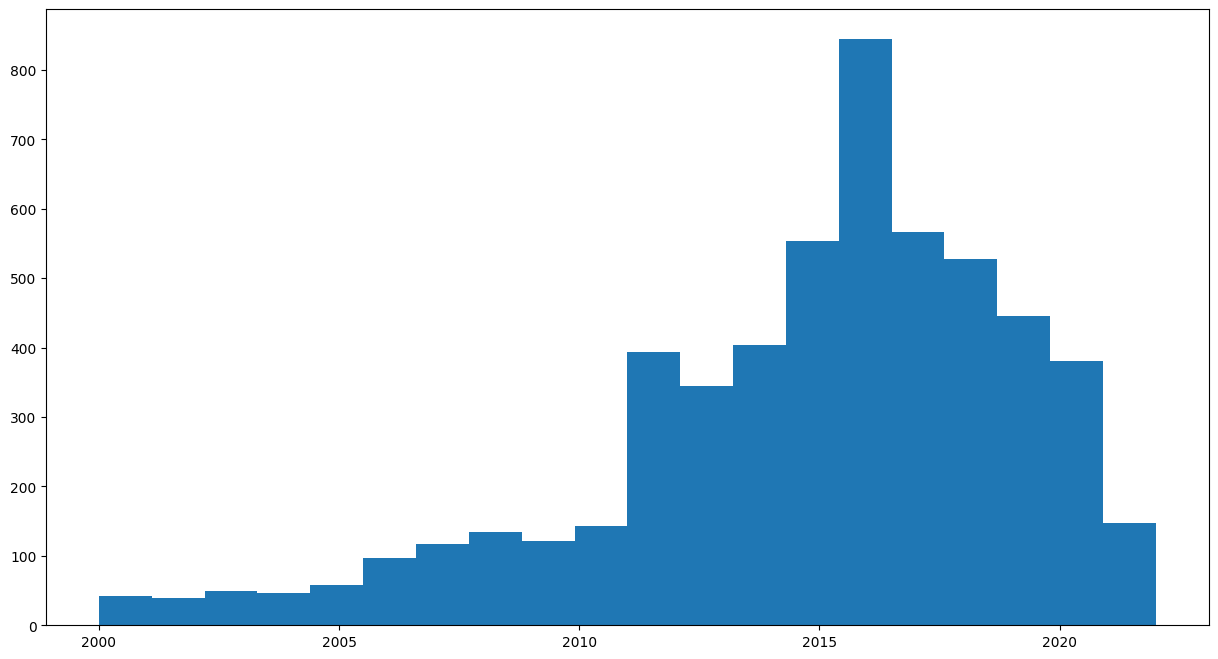

In [183]:
plt.figure(figsize=(15,8))
df = df[df['Year']>=2000]
plt.hist(df['Year'], bins=20);


In [184]:
# Calculate the frequency of each 'Type'
type_counts = df['Type'].value_counts()
type_counts[type_counts == 1].sum()
# Filter 'Type' values that appear 10 or more times
df = df[df['Type'].isin(type_counts[type_counts >= 2].index)]

In [185]:
df.shape

(5364, 11)

In [186]:
 # Calculate the frequency of each 'Make'
make_counts = df['Make'].value_counts()
make_counts[make_counts == 1].sum()

# Filter 'Type' values that appear 10 or more times
df = df[df['Make'].isin(make_counts[make_counts >=2].index)]

In [187]:
df.shape

(5364, 11)

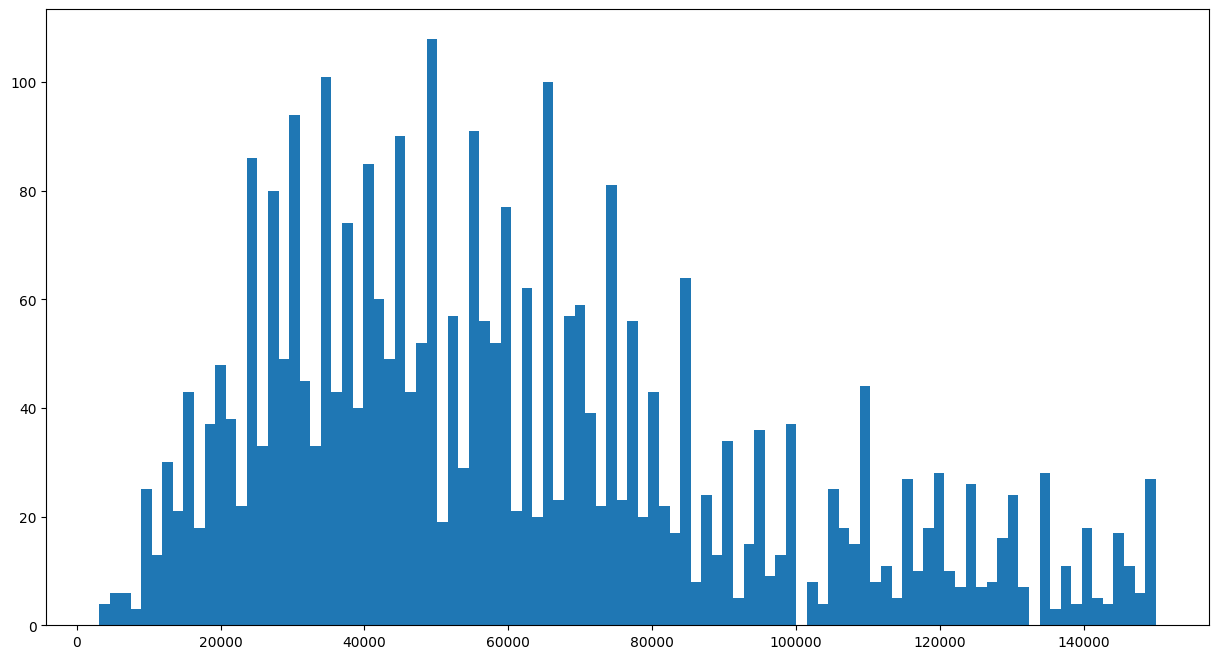

In [188]:
plt.figure(figsize=(15,8))
# plt.boxplot(df['Price']);


# plt.hist(df['Price'], bins=100); # Before filteration

plt.hist(df[(df['Price']<=150000) & (df['Price']>3000)]['Price'], bins=100); # After filteration


In [189]:
df = df[(df['Price']<=150000) & (df['Price']>=5000)]

In [190]:
df.shape

(3239, 11)

In [191]:
#df[df['Mileage']<1000]

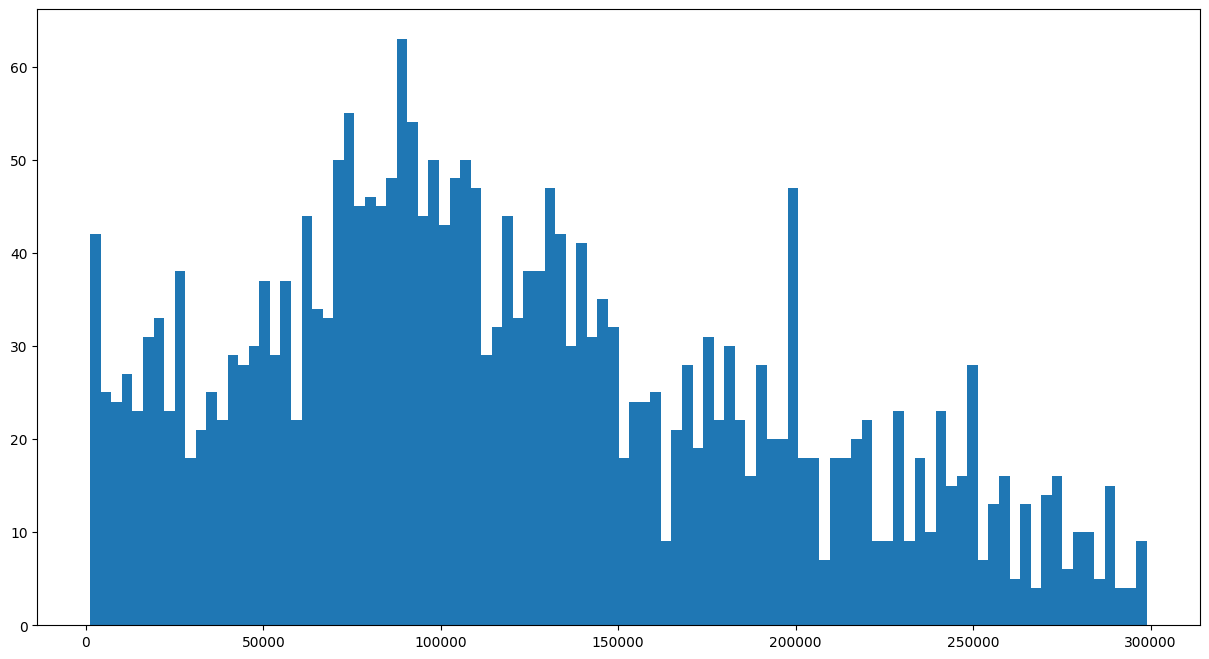

In [192]:
plt.figure(figsize=(15,8))

# plt.hist(df['Mileage']);

plt.hist(df[(df['Mileage'] < 300000) & (df['Mileage'] > 1000)]['Mileage'], bins=100);

# plt.hist(df[df['Mileage']<=450000]['Mileage'], bins=100);

In [193]:
df = df[df['Mileage']<=300000]
df.shape

(2958, 11)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [194]:
df.head(2)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000


In [195]:
categorical_features

['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']

In [196]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [197]:
df.shape

(2958, 314)

In [198]:
df.head(2)

,Year,Engine_Size,Mileage,Negotiable,Price,Type_3,Type_300,Type_3008,Type_301,Type_5,...,Make_Zhengzhou,Gear_Type_Automatic,Gear_Type_Manual,Origin_Gulf Arabic,Origin_Other,Origin_Saudi,Origin_Unknown,Options_Full,Options_Semi Full,Options_Standard
1,2014,8.0,80000,False,120000,False,False,False,False,False,...,False,True,False,False,False,True,False,True,False,False
3,2015,2.4,220000,False,42000,False,False,False,False,False,...,False,True,False,False,False,True,False,False,True,False


#### 3. Feature selection

In [199]:
correlation = df.corr()
print(correlation['Price'].sort_values(ascending=False))

Price               1.000000
Year                0.368140
Engine_Size         0.354179
Options_Full        0.244357
Make_Lexus          0.190299
                      ...   
Mileage            -0.197879
Type_Accent        -0.209852
Make_Hyundai       -0.212630
Options_Standard   -0.254663
Negotiable               NaN
Name: Price, Length: 314, dtype: float64


In [200]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['Price']) > threshold]['Price'].index
selected_features

Index(['Year', 'Engine_Size', 'Price', 'Type_Accent', 'Make_Hyundai',
       'Options_Full', 'Options_Standard'],
      dtype='object')

In [201]:
selected_features = ['Year', 'Engine_Size', 'Price', 'Type_Accent', 'Make_Hyundai',
       'Options_Full', 'Options_Standard']

In [202]:
df = df[selected_features]
df.head()

,Year,Engine_Size,Price,Type_Accent,Make_Hyundai,Options_Full,Options_Standard
1,2014,8.0,120000,False,False,True,False
3,2015,2.4,42000,False,False,False,False
5,2019,2.0,58000,False,False,False,False
6,2012,4.8,85000,False,False,True,False
7,2016,2.4,48000,False,True,True,False


#### 4. Prepare train and test data

In [203]:
# Prepare data
X = df.drop(['Price'], axis=1) # independent variable or features
y = df['Price'] # dependent variable or Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [204]:
X_train_scaled

array([[-0.68230402, -0.23694157, -0.2249926 , -0.43123649,  1.40840568,
        -0.78774866],
       [-1.24283572,  0.39698654, -0.2249926 , -0.43123649, -0.7100227 ,
         1.26944044],
       [ 0.71902524,  1.87615212, -0.2249926 , -0.43123649,  1.40840568,
        -0.78774866],
       ...,
       [ 0.15849354, -1.08217905, -0.2249926 , -0.43123649, -0.7100227 ,
         1.26944044],
       [ 0.99929109, -1.01174259, -0.2249926 , -0.43123649,  1.40840568,
        -0.78774866],
       [ 0.43875939, -1.22305196, -0.2249926 , -0.43123649, -0.7100227 ,
         1.26944044]])

In [205]:
X.shape

(2958, 6)

## Buliding the Model

In [206]:
model = LinearRegression()

In [211]:
param_grid = {
    'fit_intercept': [True, False],
}

In [212]:
# Initialize a GridSearchCV object
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error')

## Train the Model

In [213]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LinearRegression()

In [214]:
# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

Best Parameters: {'fit_intercept': True}


## Test the Model

In [215]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

In [238]:
# Predict and evaluate the best model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Best Model MSE:, {mse:2e}")

Best Model MSE:, 5.449834e+08


## Interpretation of the Model

In [217]:
coeff_df_best = pd.DataFrame(best_model.coef_,X.columns,columns=['Coefficient'])
coeff_df_best

,Coefficient
Year,5811.639624
Engine_Size,11147.535556
Type_Accent,-8836.700797
Make_Hyundai,-11742.357297
Options_Full,11031.181267
Options_Standard,-8096.726265


In [218]:
coeff_df = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Year,20736.167460
Engine_Size,15826.371933
Type_Accent,-1892.396033
Make_Hyundai,-4269.715672
Options_Full,5207.247687
Options_Standard,-3935.820136


In [220]:
print(best_model.intercept_)

-11681539.144110851


In [221]:
print(model.intercept_)

63617.85545223991


## Evaluating the Model 

1. Mean Square Error

In [222]:
y_base = [y_train.mean()] * len(y_test)

In [239]:
# our benchmark model
mse_base = mean_squared_error(y_test, y_base )
print(f'Mean Squared Error of base model: {mse_base:2e}')

Mean Squared Error of base model: 1.081716e+09


In [240]:
mse_train = mean_squared_error(y_train, model.predict(X_train_scaled))
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for training: {mse_train:2e}')
print(f'Mean Squared Error for testing: {mse_test:2e}')

Mean Squared Error for training: 5.599820e+08
Mean Squared Error for testing: 5.449834e+08


2. Mean Absolute Error

In [241]:
# our benchmark model
mse_base = mean_absolute_error(y_test, y_base )
print(f'Mean Absolute  Error of base model: {mse_base}')


Mean Absolute  Error of base model: 26496.49355595029


In [242]:
mae_train = mean_absolute_error(y_train, model.predict(X_train_scaled))
mae_test = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error for training: {mae_train}')
print(f'Mean Absolute Error for testing: {mae_test}')

Mean Absolute Error for training: 17975.353492177386
Mean Absolute Error for testing: 17642.349240307747


3. Root Mean Squared Error

In [243]:
# our benchmark model
print(f'Root Mean Squared  Error of base model: {np.sqrt(mse_base)}')

Root Mean Squared  Error of base model: 162.77743564742102


In [244]:
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test)}')

Root Mean Squared Error for training: 23663.93822513896
Root Mean Squared Error for testing: 23344.879226499113


4. R Square

In [245]:
r2_score_train = r2_score(y_train, model.predict(X_train_scaled))
r2_score_test = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train}')
print(f'R Square for testing: {r2_score_test}')

R Square for training: 0.5042695131140444
R Square for testing: 0.49293573350675346


#### Predictions vs. Real Values

In [246]:
predictions = model.predict(X_test_scaled)
#predictions

In [247]:
Real_Values = np.array(y_test)
#Real_Values

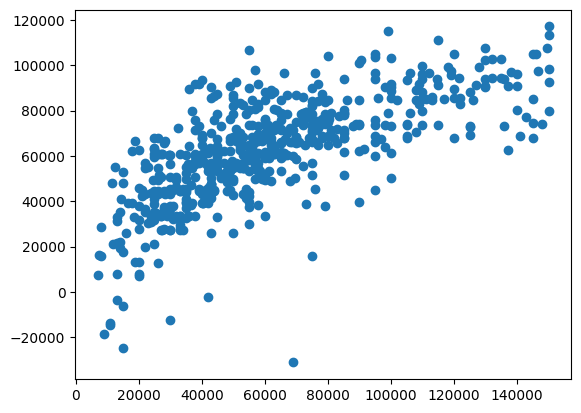

In [248]:
plt.scatter(Real_Values,predictions); 

#### Residual Histogram

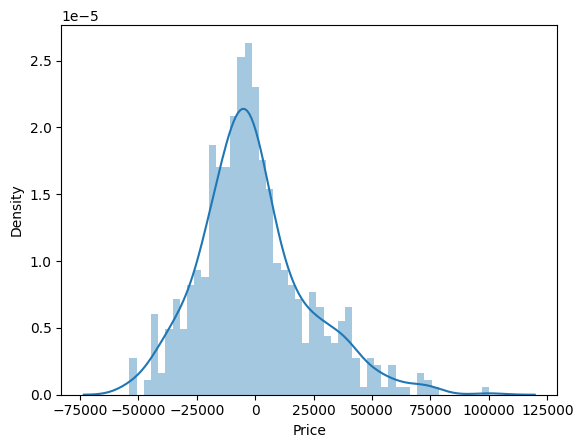

In [234]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution